# Airbnb & Zillow Data Challenge 
### Shumeng Shi -  2021/09

- Introduction <br>
- Assumptions <br>
- Define Functions <br>
- Data Preparation <br>
- Data Transformation <br>
- Visualization <br>
- Summary <br>


In [1]:
## Increase cell width for Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Step 1: Introduction
A real estate company wants to purchase two-bedroom properties in New York City to rent out short-term as part of their business model. The goal of the project is to figure out the most profitable zip code to invest in.
The available data are the estimated Zillow cost for the purchase price and the rent prices of properties on Airbnb. 

### Step 2: Assumptions

1. The time value of money discount rate is 0%.
2. All properties and all square feet within each locale can be assumed to be homogeneous.
3. Occupancy rate is 75%.
4. Cleaning fee is also part of the revenue. Since all the properties need to provide cleaning service between guests checking out and new guests are checking in. Cleaning cost is considered the sunk cost that every host needs to bear. Thus if the host charges an extra cleaning fee, that will be counted as part of the total revenue. This project assumes the average renting nights are 6, and the house gets cleaned every six days. Thus the average cleaning revenue on each day is cleaning fee / 6.
5. Import metrics: breakeven year and ROI
    - Breakeven Year: the number of years it takes for the company's revenues and expenses become equal
    - ROI: Return on investment is a performance measure used to evaluate efficiency or profitability. In this project, we use the percentage of revenue of property value over 25 years as ROI

### Step 3: Define Reusable Functions

To increase the efficiency and reusability of the code, first define multiple helpful functions for further use. 

**Function 1: clean_zip(df,zipcode)** <br>
clean_zip function takes a dataframe and the name of the zipcode column as input. The functions drop rows with missing zipcode, convert the zipcode to string and keep the first five digits.
In this case, only a few zip codes are missing, and it is hard to impute them based on other available information accurately. Dropping those can ensure data accuracy and avoid inviting extra errors.

**Function 2: clean_price(df,df, clean_col)** <br>
The clean_price function takes a dataframe and a list of columns to be cleaned as input. For each column in the list, the function trims unnecessary symbols ($ or space) from the two ends of the string and converts them to int.


**Function 3: profit_analysis(df, value, total_price, occupancy, years)** <br>
The profit_analysis function will take a dataframe and several parameters as input. Value is the estimation of property value from Zillow, total_price is the addition of daily rent and cleaning fee. Years is the ROI of specific years.


**Function 4: twinx_bar(x_label,y1,y2,xticks, w,label1, label2)** <br>
The twinx_bar function creates dual axes histogram plots side by sid. The input parameters are the x label, the value of two y variables(y1,y2), the labels of two y variables(label1,label2). w is the width of the histogram, and xticks is the number of xtickes to be included in the plot.

**Function 5: zip_map(width,height,center,df_map,color_category)** <br>
The zip_map function creates a dynamic map that marks the location based on zipcode.The parameters are: width and hieght of the figure size. The longitude and latitude of the map center point. 

In [2]:
## Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from branca.element import Figure
from geopy.geocoders import Nominatim
pd.set_option('display.float_format', lambda x: '%.0f' % x)
import warnings
warnings.filterwarnings('ignore')

C:\Users\Shumeng\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
def clean_zip(df,zipcode):
    ## get rid of the dash in the zipcode
    df = df.dropna(subset=['zipcode'])
    ## Convert the zipcode to string and get the first 5 digits
    df['zipcode'] = df['zipcode'].apply(lambda x: str(x)[:5])
    return df

def clean_price(df, clean_col):
    for col in clean_col:
        df[col] = df[col].apply(lambda x: x.lstrip('$').rstrip(' ').replace(',', ''))   ## remove special symbols $ and spaces
        df[col] = df[col].apply(lambda x: int(float(x)))   ## convert it to INT
    return df

def profit_analysis(df, value, total_price, occupancy, years):
    ## how many renting days it takes to breakeven
    df['breakeven_days'] = df[value] /df[total_price] 
    ## how many years it takes to breakeven given the occupancy rate
    df['breakeven_years'] = df['breakeven_days'] / occupancy/365
    ## ROI - the total profit among certain years (revenue - cost) / cost
    df['roi'] = (df[total_price]*365*years*occupancy - df[value]) / df[value]
    return df

def twinx_bar(x_label,y1,y2,xticks, w,label1, label2):
    fig,ax1 = plt.subplots(figsize=(15, 8))    ## define a figure and the first axis
    bar1 = range(xticks)      ## the x coordinator of first bar    
    bar2 = [i+w for i in bar1]   ## the x coordinator of second bar - is w away from the first bar
    bar_label = [i+w/2 for i in bar1]    ## the x coordinator of x axis lable - in the middle of the two bars
    ax1.bar(bar1,y1,color = "#eecbff",width = 0.4,label = label1)    ## draw the first bar chart
    ax1.grid(False)    ## hide the grid
    ax1.set_ylabel('Breakeven Years')
    ax2 = ax1.twinx() ## create second y axis
    ax2.bar(bar2,y2,color = "#95f2c7",width = 0.4, label = label2)    ## draw the second bar chart
    ax2.grid(False)
    ax2.set_ylabel('ROI')
    plt.xticks(bar_label,x_label)
    fig.legend(loc="upper right")

    
def zip_map(width,height,center,df_map,color_category):
    geolocator = Nominatim(user_agent="shumeng.shi9@gmail.com")
    for z in range(len(df_map)):
        result = geolocator.geocode({"postalcode": int(df_map.loc[z,'zipcode'])})   ## for each zipcode in the df, use geolocator to get the center coordinate of that area
        df_map.loc[z,'latitude'] = result[1][0]    ## store the latitude in df
        df_map.loc[z,'longitude'] = result[1][1]   ## store the longitude in df
    
    fig = Figure(width=width, height=height)
    m=folium.Map(width=width,height=height,location=center, tiles = 'OpenStreetMap',zoom_start=10, min_zoom = 8, max_zoom = 14)  ## create map
    for i, row in df_map.iterrows():     ## for each point in the df, mark them on the map with their longitude and latitude
        lat = df_map.loc[i,'latitude']
        lng = df_map.loc[i,'longitude']
        breakeven_years = int(df_map.loc[i,'breakeven_years'])   ## add the zipcode & neighborhood & breakeven_year & ROI onto the popup
        neighbourhood = df_map.loc[i,'neighbourhood_group_cleansed']
        ROI = round(df_map.loc[i,'roi']*100,2)
        popup = df_map.loc[i,'neighbourhood_group_cleansed'] + '<br>' +'zipcode:' +str(df_map.loc[i,'zipcode']) + '<br>' +"breakeven_years:" + str(breakeven_years) + 'yrs'+ '<br>'  + "ROI: " + str(ROI) +"%"
        if neighbourhood == color_category[0]:  ## specify different colors to different district
            color = 'blue'
        elif neighbourhood == color_category[1]:
            color = 'red'
        else:
            color = 'orange'

        folium.Marker(location = [lat,lng], popup =popup, icon = folium.Icon(color=color)).add_to(m)
    fig.add_child(m)
    return fig

### Step 4: Data Preparation

#### 4.1 Import the data and combine listing data together

In [4]:
## read the data from local csv file
z_price = pd.read_csv('Zip_Zhvi_2bedroom.csv')
list_1 = pd.read_csv('listings_file_1_of_4.csv')
list_2 = pd.read_csv('listings_file_2_of_4.csv', header = None)
list_3 = pd.read_csv('listings_file_3_of_4.csv', header = None)
list_4 = pd.read_csv('listings_file_4_of_4.csv', header = None)

## change the column name 
list_2.columns = list(list_1.columns)
list_3.columns = list(list_1.columns)
list_4.columns = list(list_1.columns)

## combine all the listings file together as big table
listing = pd.concat([list_1, list_2,list_3,list_4],axis = 0)

#### 4.2 Select Relevant Data
1. Zillow Price:
    - Rows Selection: The analysis confines two-bedroom properties in NYC. Limit data entry to only in NYC. Because the city column in Zillow df is messy and many are incorrectly tagged, we decided to use the state column and metro to limit NYC entries.
    - Columns selection: The property price from many years ago can't accurately reflect its value today. Also, there are many missing values in those columns. We only keep the most recent years' cost as a reference.
2. Airbnb listing:
    - Rows Selection:For the Airbnb listing data, New York comprises five areas: Brooklyn, Queens, Manhattan, the Bronx. Select those areas in the Airbnb data with two bedrooms. 
    - Columns selection:There are many host and facilities information related to the specific property in the Airbnb data. Those don't bring value in analyzing the profitability by zipcode. Thus, we only keep the location-related information for further analysis.

In [5]:
## filter out to values only for NYC
z_price = z_price[(z_price['State'] == 'NY') & (z_price['Metro'] == 'New York')].reset_index()
listing = listing[(listing['state'].str.contains('NY','New York')) & (listing['city'].str.lower().str.contains("new york|brooklyn|queens|manhattan|bronx")) & (listing['bedrooms'] == 2)].reset_index()


## select only related features，any host related features and facility amendity features are not relavent, because we only care about the property itself, not the add -on values
listing = listing[['street','neighbourhood_group_cleansed','city','state','zipcode','latitude','longitude','square_feet','price','cleaning_fee']]

## for the zillow data set, we choose the latest price level for analysis
z_price = z_price[['RegionName','SizeRank','2017-01','2017-02','2017-03','2017-04','2017-05','2017-06']]
z_price['avg_price'] = z_price[['2017-01','2017-02','2017-03','2017-04','2017-05','2017-06']].mean(axis=1)

print("The shape of zillow table " + str(z_price.shape))
print("The shape of listing table " + str(listing.shape))

The shape of zillow table (156, 9)
The shape of listing table (4769, 10)


#### 4.3 Data Cleaning  - Perform outlier detection, null value imputation, data cleanup to ensure data quality
##### 4.3.1 Zillow price

In [6]:
## Check null value and duplicated rows
print(z_price.isnull().sum()) 
print("There are " + str(sum(z_price.duplicated(['RegionName']))) +" duplicated zipcode in the table")
print("There are " + str(sum(z_price.duplicated())) +" duplicated row in the table")

## change column name from RegionName to zipcode
z_price = z_price.rename(columns={"RegionName": "zipcode"})
## use the cusomized function "clean_zip" to clean the zipcode in the z_price df
z_price = clean_zip(z_price,'zipcode')

RegionName    0
SizeRank      0
2017-01       0
2017-02       0
2017-03       0
2017-04       0
2017-05       0
2017-06       0
avg_price     0
dtype: int64
There are 0 duplicated zipcode in the table
There are 0 duplicated row in the table


There is no null value and no duplicatd rows in the zillow dataset. Next, examine the distribution of the price column by ploting the histogram of prices in 2017-06 and the average prices in the past 6 months side by side.

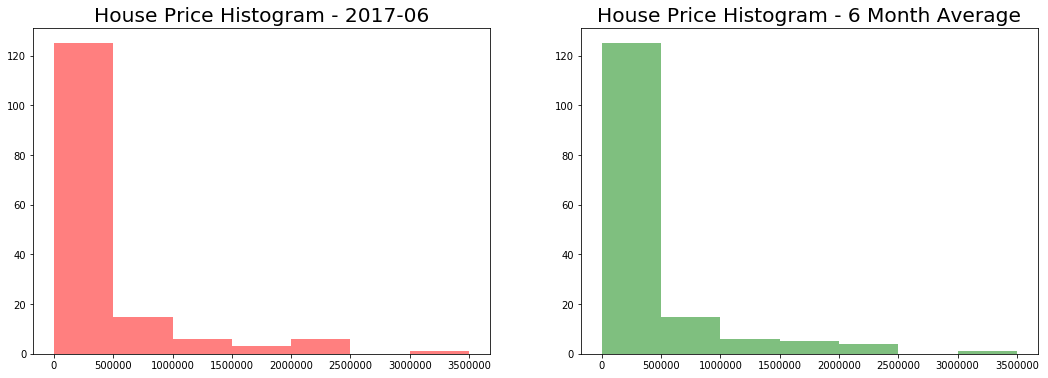

In [7]:
## plot the distribution of price on 201706
## even though some of the house have very large value, but I checked the values in the past few months, they are pretty steady, so they are not outlier
fig, ax = plt.subplots(1,2,figsize=(18, 6))
#plt.figure(figsize=(8, 6), dpi=80)
prices_x = z_price['2017-06']
prices_x_2 = z_price['avg_price']
plt.style.use("fivethirtyeight")
bins = [0,500000, 1000000, 1500000,2000000,2500000,3000000,3500000]
# prices_x.hist(bins = bins, ax = axes[0],edgecolor = 'black')
# prices_x_2.hist(bins = bins, ax = axes[1],edgecolor = 'black')
# plt.show()

ax[0].hist(prices_x, bins, alpha = 0.5, color = 'r', label = '2017-06 price')

ax[1].hist(prices_x_2, bins, alpha = 0.5, color = 'g', label = '6 month average price')
ax[0].set_title('House Price Histogram - 2017-06')
ax[1].set_title('House Price Histogram - 6 Month Average')
##fig.legend(loc="upper right")

plt.show()

z_price = z_price[['zipcode','SizeRank','2017-06']]

After plotting the distribution of house prices on 2017-06, and the price distribution of the six-month average (2017-01 to 2017-06), there is no significant difference between these two. We can conclude that even if very few properties have extremely high prices, that is likely not an error but a fair value. Also, we will use the last month as the final analysis price due to no significant difference between those.

##### 4.3.2 Airbnb data - Drop out square_feet and clean up price, cleaning_fee and zipcode

In [8]:
## get the % of missing value
pd.set_option('display.float_format', lambda x: '%.2f' % x)
listing.isnull().sum() / len(listing)

street                         0.00
neighbourhood_group_cleansed   0.00
city                           0.00
state                          0.00
zipcode                        0.01
latitude                       0.00
longitude                      0.00
square_feet                    0.98
price                          0.00
cleaning_fee                   0.20
dtype: float64

98% of the square feet is missing, and it does not bring us valuable information. For analysis purposes, delete the column. About 20% of the cleaning fee is empty, impute the empty value with 0.

In [9]:
## because 98% of the square_feet is null, delete the column 
listing = listing.drop(['square_feet'], axis = 1)
listing['cleaning_fee'] = listing['cleaning_fee'].fillna('0')
## Clean the price, cleaning_fee and zipcode with customized function
listing = clean_price(listing, ['price','cleaning_fee'])
listing = clean_zip(listing,'zipcode')

### Step 5: Data Transformation -- Join Zillow data and Airbnb data, conduct profitability analysis and select zipcode

In [10]:
df = pd.merge(left=listing, right=z_price, left_on='zipcode', right_on='zipcode')
## We assume the apartment is cleaned every six days, the daily revenue of cleaning fee is 1/6 of the total cleaning_fee
df['total_price'] = df['price'] + df['cleaning_fee'] / 6
## rename the value column
df = df.rename(columns={"2017-06": "value"})
df = df.drop(['street','city','state','price','cleaning_fee','SizeRank','latitude','longitude'], axis = 1)

After applying the customized function profit_analysis to get the breakeven years of each property and the ROI of a 25-year investment period, calculate the average breakeven year and ROI of all the properties in that zip code. Select the common nine zip codes that are on the top of both lists.

In [11]:
df = profit_analysis(df,'value','total_price',0.75,25)
df_agg = df.groupby(['zipcode','neighbourhood_group_cleansed']).mean()
df_agg = df_agg.sort_values(by=['breakeven_years'], ascending=True).reset_index()

zip_years = list(df_agg.sort_values(by=['breakeven_years'], ascending=True)[:10]['zipcode'])
zip_roi = list(df_agg.sort_values(by=['roi'], ascending=False)[:10]['zipcode'])
zip_selected = set(zip_roi) & set(zip_years)
zip_selected

{'10022',
 '10025',
 '10036',
 '11201',
 '11215',
 '11217',
 '11231',
 '11234',
 '11434'}

### Step 6: Data Visualization - Plot the breakeven year and ROI to select recommended zipcode

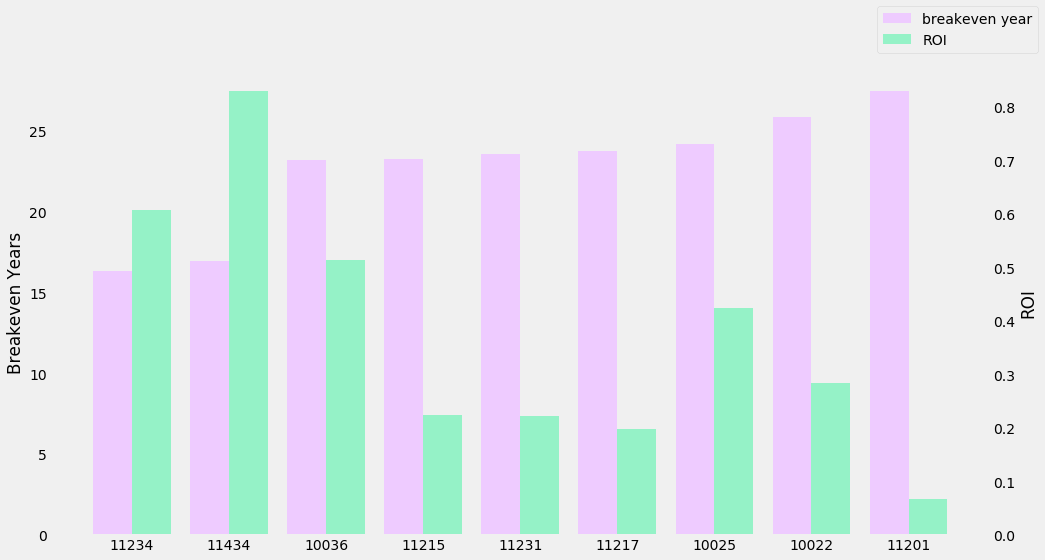

In [12]:
year_y = df_agg[df_agg.zipcode.isin (zip_selected)]['breakeven_years']
roi_y = df_agg[df_agg.zipcode.isin (zip_selected)]['roi']
zip_selected = df_agg[df_agg.zipcode.isin (zip_selected)]['zipcode']
## Apply the customized function to make the bar charts
twinx_bar(zip_selected,year_y,roi_y,9,0.4,"breakeven year","ROI")

The side-by-side bar chart shows that the first two zip codes - 11234 and 11434 have the smallest breakeven year, about 16 years. And zipcode 1,2,3,7 have relatively high ROI, ranging from 40% to 60%. Based on the above analysis, we decide to recommend those 4 zip codes for purchase - ['11234','11434','10036','10025']

In [13]:
zip_recommend = ['11234','11434','10036','10025']
## filter only those 4 zipcodes to plot on map
df_map =df_agg[df_agg.zipcode.isin(zip_recommend)].reset_index(drop = True)
## use the customized zip_map function to plot the marks on the map
zip_map(650,450,[40.7850,-73.9682],df_map,['Manhattan','Brooklyn','Queens'])

### Step 7: Summary

In [14]:
df_map

,zipcode,neighbourhood_group_cleansed,value,total_price,breakeven_days,breakeven_years,roi,latitude,longitude
0,11234,Brooklyn,476900,112.06,4475.73,16.35,0.61,40.62,-73.92
1,11434,Queens,382300,102.22,4647.43,16.98,0.83,40.68,-73.78
2,10036,Manhattan,1712900,378.76,6346.31,23.18,0.51,40.76,-73.99
3,10025,Manhattan,1431000,297.79,6626.67,24.21,0.42,40.80,-73.97


We recommend 4 zipcodes to invest in based on their breakeven year and higher ROI among 25-year period.
- **zipcode 11434 in Queens**: Among the four recommended zipcodes, properties in Queens have the lowest value on Zillow compared to other districts in NYC like Manhattan.  It costs about \\$380k, and the average daily rent is \\$102. It will take about 17 years to break even and start earning profit. After 25 years of operation, the ROI will be 83%.
- **zipcode 11234 in Brooklyn**: Among the four recommend zipcodes, the property cost in Brooklyn is in the middle.  It costs about \\$476k, and the average daily rent is \\$112. It will take about 16 years to break even and start earning profit. After 25 years of operation, the ROI will be 61%.
- **zipcode 10036 in Manhanttan**: Among the four recommended zipcodes, Manhattan's property cost and daily rent are the highest, and it takes longer to break even.  It costs about \\$1.7M, and the average daily rent is \\$378. It will take about 23 years to break even and start earning profit. After 25 years of operation, the ROI will be 51%. But once it breaks even, the profit growth speed is higher due to the higher daily rent.
- **zipcode 10036 in Manhanttan**: Among the four recommend zipcodes, the property cost in Manhanttan and daily rent are the highest, and it takes longer to break even.  It costs about \\$1.7M, and the average daily rent is \\$297. It will take about 24 years to break even and start earning profit. After 25 years of operation, the ROI will be 42%.


### Step 8: Future Steps

- **Missing zip code in the listing table**: Due to time limitations, we drop the records with missing zip codes in the analysis. With more time, it would be better to leverage $geopy.geocoders$ library to get the valid zip code from longitude and latitude. That will give us more information and help make a better decision
- **Property cost**: In the analysis, we use the Zillow cost from 2017/06 as the cost for analysis. Suppose the analysis is conducted to help make a decision today in 2021. In that case, we can either collect more recent dates or run a time series model to predict the property cost to reflect the situation better.
- **Discount rate**: In this case, we use the daily rent in the calculation. If time permits, we could better estimate the average renting period in different districts or zipcodes. Then we could use the weekly rent and monthly rent to predict revenue and profit better. 
- **Model in predicting occupancy rate**: Instead of using the universal 75% across all properties, we could run a machine learning model with property features(amenities, location), host information, and renter reviews to get a customized occupancy rate for different districts
- **More metrics to evaluate recommended zipcode**: If time permits, we can add more metrics in our analysis, like the annual revenue, annual profit, ROI in 10 years, 20 years, 30 years, etc. Also, instead of getting the average of those metrics across all properties from a specific zip code, we could calculate each zipcode's median or mode to complement our analysis.